# **Di chuyển đến thư mục làm việc**

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
cd /content/drive/MyDrive/PBL5

/content/drive/.shortcut-targets-by-id/1-VazRbs1t_EDwA_O5hAtA7-GV8f_IHJE/PBL5


# **Cài và khai báo thư viện**

In [4]:
!pip install --upgrade scikit-learn
!pip install --upgrade ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.4/595.4 kB 15.5 MB/s eta 0:00:00


In [5]:
import os
import cv2
import math
import time
import datetime
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical, plot_model
from google.colab.patches import cv2_imshow

from sklearn.utils import class_weight
from keras import backend as K
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix
from ultralytics import YOLO
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
import seaborn as sns
from keras.callbacks import CSVLogger

# **Các hàm xử lý**

In [6]:
# lưu file npy (features của dataset)
def save_to_npy(label, features):
    with open(label, "wb") as f:
        np.save(f, features)
        f.close()


# Lấy tất cả đường dẫn của tập dataset
def get_list_video():
    videos = []
    folder_path = 'Dataset'
    for sub_folder in os.listdir(folder_path):
        # Duyệt qua tất cả các file video
        for filename in os.listdir(os.path.join(folder_path, sub_folder)):
            video_path = os.path.join(folder_path, sub_folder)
            video_path = os.path.join(video_path, filename)
            videos.append(video_path)
    return videos


# lấy đặc trưng của 1 frame
def get_feature(mask, s):
    h, w = mask.shape

    # Tính ROI (Region Of Interest: vùng quan tâm) các vùng A1, A2, A3, A4, A5
    roi = [0, 0, 0, 0, 0]

    coor = (w // 2, h // 2)
    tan55 = 1.428  # tan(55)

    for i in range(h):
        i = i - coor[1]
        for j in range(w):
            j = j - coor[0]
            if (j <= 0) and (j - i > 0):
                roi[0] += mask[i, j]
            elif (j > 0) and (j + i <= 0):
                roi[1] += mask[i + coor[1], j + coor[0]]
            elif (j - i <= 0) and (i + tan55 * j <= 0):
                roi[2] += mask[i + coor[1], j + coor[0]]
            elif (j + i > 0) and (i - tan55 * j > 0):
                roi[3] += mask[i + coor[1], j + coor[0]]
            else:
                roi[4] += mask[i + coor[1], j + coor[0]]
    
    return [r / sum(roi) for r in roi]

# **Lấy features cho 1 video**

In [7]:
def handle_video_features(video_path, timestep, X_all, Y_all):
    cap = cv2.VideoCapture(video_path)
    X = []
    # Loop through the video frames-pip install protobuf==3.20.*
    count = 0
    label = 1 if 'fall' in video_path else 0
    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()
        if not success:
            break
        # Run YOLOv8 inference on the frame
        results = modelYOLO(frame)
        # If not exist person
        if results[0].masks is None:
            continue
        h, w, c = frame.shape

        s = h * w

        # get box object
        box = results[0].boxes[0].xyxy[0]
        box = box.cpu().numpy().astype(int)
        x1, y1, x2, y2 = box

        # s = abs(x1 - x2) * abs(y1 - y2)

        # background subtraction
        mask = (results[0].masks.data[0].cpu().numpy() * 255).astype('uint8')
        # resize size mask equal size original frame
        mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
        # get bounding box person
        mask = mask[y1:y2, x1:x2]
        if len(X) < timestep:
            X.append(get_feature(mask, s))
        else:
            X = X[1:] + [get_feature(mask, s)]
            
            X_all.append(X)
            Y_all.append(label)

        if cv2.waitKey(1) == ord('q'):
            break
      

# **Lấy features cho tập dataset**

In [8]:
def create_dataset_feature(videos, number_frame_of_observation):
    X_all, Y_all = [], []
    # Duyệt qua tất cả các tệp trong thư mục
    for video in videos:
        handle_video_features(video, number_frame_of_observation, X_all, Y_all)
    save_to_npy(f'_Top-down-Framework/features/features_{number_frame_of_observation}frames.npy', np.array(X_all))
    save_to_npy(f'_Top-down-Framework/features/labels_{number_frame_of_observation}frames.npy', np.array(Y_all))

In [9]:
modelYOLO = YOLO('_Top-down-Framework/best.pt')

In [10]:
videos = get_list_video()
random.Random(28).shuffle(videos)

print(len(videos))

430


In [11]:
for number_frame_of_observation in [40]:
  print(number_frame_of_observation)
  create_dataset_feature(videos, number_frame_of_observation)

40


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
0: 480x640 1 person, 9.9ms
Speed: 1.4ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 9.2ms
Speed: 4.3ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 16.6ms
Speed: 1.6ms preprocess, 16.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.8m

# **Train model LSTM**

In [8]:
def recall_m(y_true, y_pred):
    true_positives1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives1 = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall1 = true_positives1 / (possible_positives1 + K.epsilon())

    return recall1

def precision_m(y_true, y_pred):
    true_positives1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives1 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision1 = true_positives1 / (predicted_positives1 + K.epsilon())

    return precision1

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
def trainLSTM(timestep, version):
  with open(f'/content/drive/MyDrive/PBL5/_Top-down-Framework/features/features_{timestep}frames.npy', "rb") as f:
    X = np.load(f)
    f.close()
  with open(f'/content/drive/MyDrive/PBL5/_Top-down-Framework/features/labels_{timestep}frames.npy', "rb") as f:
      y = np.load(f)
      f.close()


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=0, stratify=y_train)
  save_to_npy(f'_Top-down-Framework/features/train/features_{timestep}frames_train_v{version}', X_train)
  save_to_npy(f'_Top-down-Framework/features/train/labels_{timestep}frames_train_v{version}', y_train)
  save_to_npy(f'_Top-down-Framework/features/val/features_{timestep}frames_val_v{version}', X_val)
  save_to_npy(f'_Top-down-Framework/features/val/labels_{timestep}frames_val_v{version}', y_val)
  save_to_npy(f'_Top-down-Framework/features/test/features_{timestep}frames_test_v{version}', X_test)
  save_to_npy(f'_Top-down-Framework/features/test/labels_{timestep}frames_test_v{version}', y_test)

  modelLSTM = Sequential() # Stacked LSTM
  modelLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(timestep, 5)))
  modelLSTM.add(Dropout(0.2))
  modelLSTM.add(LSTM(units=50, return_sequences=True))
  modelLSTM.add(Dropout(0.2))
  modelLSTM.add(LSTM(units=50, return_sequences=True))
  modelLSTM.add(Dropout(0.2))
  modelLSTM.add(LSTM(units=50))
  modelLSTM.add(Dropout(0.2))
  modelLSTM.add(Dense(units=1, activation='sigmoid')) 
  from keras.optimizers import Adam
  optimizer = Adam(learning_rate=0.001)
  modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])


  csv_logger = CSVLogger(f'_Top-down-Framework/Result/{timestep}frames_v{version}/history.csv', append=True, separator=',')
  history = modelLSTM.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[csv_logger])
  modelLSTM.save(f'/content/drive/MyDrive/PBL5/_Top-down-Framework/modelLSTM/model_lstm_{timestep}frames_v{version}.h5')


  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(f'_Top-down-Framework/Result/{timestep}frames_v{version}/accuracy.png')
  plt.close()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  # plt.show()
  plt.savefig(f'_Top-down-Framework/Result/{timestep}frames_v{version}/loss.png')
  plt.close()
  # summarize history for f1
  plt.plot(history.history['f1_m'])
  plt.plot(history.history['val_f1_m'])
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  # plt.show()
  plt.savefig(f'_Top-down-Framework/Result/{timestep}frames_v{version}/f1.png')
  plt.close()

In [10]:
for number_frame_of_observation in [30, 35, 40]:
  for version in [1, 2, 3]:
    print('Number frame of observation: {}, version: {}'.format(number_frame_of_observation, version))
    trainLSTM(number_frame_of_observation, version)

Number frame of observation: 30, version: 1
Epoch 1/30
511/511 [==============================] - 33s 19ms/step - loss: 0.3451 - accuracy: 0.8648 - f1_m: 0.6577 - val_loss: 0.3031 - val_accuracy: 0.8791 - val_f1_m: 0.7145
Epoch 2/30
511/511 [==============================] - 9s 17ms/step - loss: 0.2851 - accuracy: 0.8921 - f1_m: 0.7518 - val_loss: 0.2936 - val_accuracy: 0.8937 - val_f1_m: 0.7311
Epoch 3/30
511/511 [==============================] - 7s 14ms/step - loss: 0.2628 - accuracy: 0.9028 - f1_m: 0.7745 - val_loss: 0.2672 - val_accuracy: 0.9001 - val_f1_m: 0.7455
Epoch 4/30
511/511 [==============================] - 9s 17ms/step - loss: 0.2431 - accuracy: 0.9080 - f1_m: 0.7889 - val_loss: 0.2528 - val_accuracy: 0.9053 - val_f1_m: 0.7880
Epoch 5/30
511/511 [==============================] - 7s 15ms/step - loss: 0.2234 - accuracy: 0.9174 - f1_m: 0.8131 - val_loss: 0.2243 - val_accuracy: 0.9224 - val_f1_m: 0.8230
Epoch 6/30
511/511 [==============================] - 9s 17ms/step - l

## **Kết quả test**

In [ ]:
# Compile the model with the confusion matrix metric
def confusion_matrix_metric(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel() #Hàm ravel() được sử dụng để làm phẳng ma trận nhầm lẫn thành một mảng 1 chiều, sau đó được giải nén thành bốn biến.
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * precision * recall / (precision + recall) #harmonic mean of precision and recall
  return f1_score

def test(timestep, version):
  dependencies = {
    'f1_m': f1_m
  }
  modelLSTM = tf.keras.models.load_model(f'/content/drive/MyDrive/PBL5/_Top-down-Framework/modelLSTM/model_lstm_{timestep}frames_v{version}.h5', dependencies)

  with open(f'_Top-down-Framework/features/test/features_{timestep}frames_test_v{version}', "rb") as f:
      X_test = np.load(f)
      f.close()
  with open(f'_Top-down-Framework/features/test/labels_{timestep}frames_test_v{version}', "rb") as f:
      y_test = np.load(f)
      f.close()
  scores = modelLSTM.evaluate(X_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])

  modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', confusion_matrix_metric])

  # Make predictions on test data
  y_pred = modelLSTM.predict(X_test)

  # RMSE
  rmse_result = rmse(y_test, y_pred)
  print('rmse_Result: ', rmse_result)

  # Làm tròn 0, 1
  y_pred = (modelLSTM.predict(X_test) > 0.5).astype("int32")

  # Print confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print(cm)

  # Visualize confusion matrix
  sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  # plt.show()
  plt.savefig(f'_Top-down-Framework/Result/{timestep}frames_v{version}/confusion_matrix.png')
  plt.close()

In [ ]:
for timestep in [30, 35, 40]:
  print('timestep', timestep)
  for version in [1, 2, 3]:
    print('version', version)
    test(timestep, version)

timestep 30
version 1
150/150 [==============================] - 3s 7ms/step - loss: 0.0232 - accuracy: 0.9921 - f1_m: 0.9835
Test loss: 0.023241009563207626
Test accuracy: 0.9920568466186523
150/150 [==============================] - 2s 4ms/step
rmse_Result:  0.6082619112522553
150/150 [==============================] - 1s 4ms/step
[[3564   15]
 [  23 1182]]
version 2
150/150 [==============================] - 2s 6ms/step - loss: 0.0244 - accuracy: 0.9912 - f1_m: 0.9806
Test loss: 0.02435060404241085
Test accuracy: 0.9912207126617432
150/150 [==============================] - 2s 6ms/step
rmse_Result:  0.6066516688972178
150/150 [==============================] - 1s 6ms/step
[[3572    7]
 [  35 1170]]
version 3
150/150 [==============================] - 2s 6ms/step - loss: 0.0152 - accuracy: 0.9958 - f1_m: 0.9919
Test loss: 0.01515480037778616
Test accuracy: 0.9958193898200989
150/150 [==============================] - 2s 4ms/step
rmse_Result:  0.6086730787277363
150/150 [=============

# **Train model SVM**

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [ ]:
timestep = 20
param_grid = {'C': [1], 'kernel': ['linear', 'rbf']}

In [ ]:
with open(f'/content/drive/MyDrive/PBL5/_Top-down-Framework/features/features_{timestep}frames.npy', "rb") as f:
    X = np.load(f)
    f.close()
with open(f'/content/drive/MyDrive/PBL5/_Top-down-Framework/features/labels_{timestep}frames.npy', "rb") as f:
      y = np.load(f)
      f.close()

In [ ]:
X = X.reshape([len(X), 5 * timestep])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, shuffle=True)

In [ ]:
svclassifier = SVC()
grid_search = GridSearchCV(svclassifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1], 'kernel': ['linear', 'rbf']})

accuracy = 0.9515316827528326
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3768
           1       0.97      0.79      0.87       998

    accuracy                           0.95      4766
   macro avg       0.96      0.89      0.92      4766
weighted avg       0.95      0.95      0.95      4766

[[3744   24]
 [ 207  791]]
Best value of C: 10


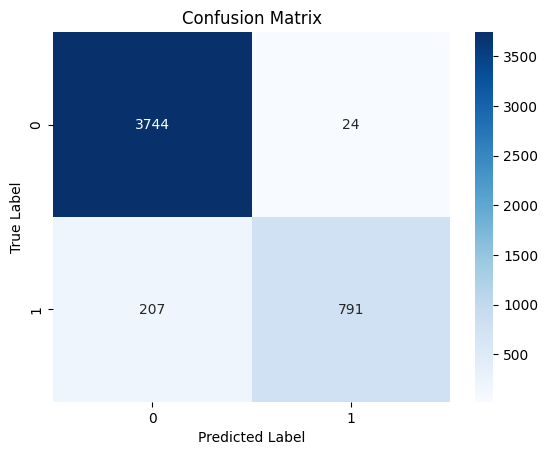

In [ ]:
y_pred = grid_search.predict(X_test)

print('accuracy =', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# print("Best value of C:", grid_search.best_params_['C'])

# Visualize confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
best_C = grid_search.best_params_['C']
svclassifier_best = SVC(kernel='linear', C=best_C)
svclassifier_best.fit(X_train, y_train)

# Save the trained model
joblib.dump(svclassifier_best, f'/content/drive/MyDrive/PBL5/_Top-down-Framework/SVMmodels/svm_trained{timestep}_C{best_C}.pkl')

['/content/drive/MyDrive/PBL5/_Top-down-Framework/SVMmodels/svm_trained20_C10.pkl']